<a href="https://colab.research.google.com/github/littlejacinthe/Audio_NeuralStyle/blob/master/copy_neural_style_audio_cqt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Audio Neural Style Transfer with Pytorch
============================
This is an implementation of neural style transfer using the alogrithm developed in
[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge.

However instead of learning style from images we use the spectrogram in place to carry out the procedure on audio.

General implementation is based off the [Pytorch tutorial on Neural Transfer](http://pytorch.org/tutorials/advanced/neural_style_tutorial.html) by Alexis Jacq. Also inspired by [Audio texture synthesis](https://github.com/DmitryUlyanov/neural-style-audio-torch) by Dmitry Ulyanov.

In [2]:
%matplotlib inline

#from __future__ import print_function

import numpy as np
from numpy import matlib as mb
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import librosa
from IPython.display import Audio, display
from PIL import Image
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats

import torchvision.transforms as transforms
import torchvision.models as models
from audiocnn import CNN 
import pickle

import copy
import os
import math

In [3]:
use_cuda = torch.cuda.is_available() #use GPU if available
print('GPU available =',use_cuda)
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

GPU available = True


In [4]:
# set filenames
STYLE_FILENAME = "/content/classical_03.wav" #input filename
savename_style = 'CrichSrooster_cqt'
CONTENT_FILENAME = "/content/jazz_05.wav" #'inputs/gettysburg.mp3' #input filename
outname = 'input' #output dir
runs = 1 # no. of separate outputs (to test consistency), 1 if only want single output

#librosa audio params
N_FFT = 1024
K_HOP = 256
# architecture

"""load model"""
model_path = None #"/home/huzaifah/Documents/CNN-pytorch/1dfreq/2017-11-23_18-24-01_cnn_epoch30.pth"
param_pkl = None #"/home/huzaifah/Documents/CNN-pytorch/1dfreq/params"
use01scale = True #set to true if want to scale img to [0,1] prior to training. Recommended if using VGG19
boundopt = True #whether to regularize the input within [lower,upper]. Recommended if using VGG19

whichChannel = "freq" #2d=2d conv, 1d options:freq=freq bins as channels, time= time bins as channels 
N_FILTERS = 4096 #no. of filters in 1st conv layer
hor_filter = 11 #width of conv filter, for 2d also the height of (square) kernel

In [5]:
display(Audio(STYLE_FILENAME))

In [6]:
# some utilities

def save_obj(obj, name):
    with open(name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [7]:
def read_audio_spectum(filename):
    x, fs = librosa.load(filename) #x=audiodata, fs=samplerate
    R = np.abs(librosa.stft(x, n_fft=N_FFT, hop_length=K_HOP, win_length=N_FFT, center=True))
    return R, fs

def log_scale(img):
    img = np.log1p(img)
    return img

def inv_log(img):
    img = np.exp(img) - 1.
    return img

def findMinMax(img):
    return int(math.floor(np.amin(img))),int(math.ceil(np.amax(img)))

def img_scale(img,datasetMin,datasetMax,scaleMin,scaleMax):
    """scales input numpy array from [datasetMin,datasetMax] -> [scaleMin,scaleMax]"""    
    shift = (scaleMax-scaleMin) / (datasetMax-datasetMin)
    scaled_values = shift * (img-datasetMin) + scaleMin
    print("Using [{0},{1}] -> [{2},{3}] for scale conversion".format(datasetMin,datasetMax,scaleMin,scaleMax))
    return scaled_values

def img_invscale(img,datasetMin,datasetMax,scaleMin,scaleMax):
    """scales input numpy array from [scaleMin,scaleMax] -> [datasetMin,datasetMax]"""
    shift = (datasetMax-datasetMin) / (scaleMax-scaleMin)
    scaled_values = shift * (img-scaleMin) + datasetMin
    print("Using [{0},{1}] -> [{2},{3}] for scale conversion".format(scaleMin,scaleMax,datasetMin,datasetMax))
    return scaled_values
    

# use below functions to use librosa db scale, normalized to [0,1]
# note that this scaling does not work well for style transfer
def db_scale(img,scale=80.):
    img = librosa.amplitude_to_db(img)
    print("amplitude_to_db:",np.amin(img),np.amax(img))
    shift = float(np.amax(img))
    img = img - shift #put max at 0
    print("amplitude_to_db:",np.amin(img),np.amax(img))
    img = img/scale #scale from [-80,0] to [-1,0]
    print("amplitude_to_db:",np.amin(img),np.amax(img))
    img = img + 1. #shift to [0,1]
    print("amplitude_to_db:",np.amin(img),np.amax(img))
    img = np.maximum(img, 0.) #clip anything below 0
    print("amplitude_to_db:",np.amin(img),np.amax(img))
    return img, shift

def inv_db(img,shift=0.,scale=80.):
    img = img - 1. #shift from [0,1] to [-1,0]
    print("db_to_amplitude:",np.amin(img),np.amax(img))
    img = img * scale #[-1,0] -> [-80,0]
    print("db_to_amplitude:",np.amin(img),np.amax(img))
    img = img + shift
    print("db_to_amplitude:",np.amin(img),np.amax(img))
    img = librosa.db_to_amplitude(img)  
    print("db_to_amplitude:",np.amin(img),np.amax(img))
    return img


In [8]:
def logfmap(I, L, H) :
    """
    % [M,N] = logfmap(I,L,H)
    I - number of rows in the original spectrogram
    L - low bin to preserve
    H - high bin to preserve
    
    %     Return a maxtrix for premultiplying spectrograms to map
    %     the rows into a log frequency space.
    %     Output map covers bins L to H of input
    %     L must be larger than 1, since the lowest bin of the FFT
    %     (corresponding to 0 Hz) cannot be represented on a 
    %     log frequency axis.  Including bins close to 1 makes 
    %     the number of output rows exponentially larger.
    %     N returns the recovery matrix such that N*M is approximately I
    %     (for dimensions L to H).
    %     
    % Ported from MATLAB code written by Dan Ellis:
    % 2004-05-21 dpwe@ee.columbia.edu
    """
    ratio = (H-1)/H;
    opr = np.int(np.round(np.log(L/H)/np.log(ratio))) #number of frequency bins in log rep + 1
    print('opr is ' + str(opr))
    ibin = L*np.exp(list(range(0,opr)*-np.log(ratio)))  #fractional bin numbers (len(ibin) = opr-1)
    
    M = np.zeros((opr,I))
    eps=np.finfo(float).eps
    
    for i in range(0, opr) :
        # Where do we sample this output bin?
        # Idea is to make them 1:1 at top, and progressively denser below
        # i.e. i = max -> bin = topbin, i = max-1 -> bin = topbin-1, 
        # but general form is bin = A exp (i/B)

        tt = np.multiply(np.pi, (list(range(0,I))-ibin[i]))
        M[i,:] = np.divide((np.sin(tt)+eps) , (tt+eps));

    # Normalize rows, but only if they are boosted by the operation
    G = np.ones((I));
    print ('H is ' + str(H))
    G[0:H] = np.divide(list(range(0,H)), H)
    
    N = np.transpose(np.multiply(M,mb.repmat(G,opr,1)))
                   
    return M,N


def spect2CQT(img, fftSize, lowRow=10):
    """ 
        Creates psuedo constant-Q spectrograms from linear frequency spectrograms. 
        Creates class folders in outdir with the same structure found in topdir.
        
        Parameters
            topdir - the dir containing class folders containing png (log magnitude) spectrogram files. 
            outdir - the top level directory to write psuedo constantQ files to (written in to class subfolders)
            lowRow is the lowest row in the FFT that you want to include in the psuedo constant Q spectrogram
    """ 
    
    # First lets get the logf map we want
    LIN_FREQ_BINS = int(N_FFT/2+1) #number of bins in original linear frequency mag spectrogram
    LOW_ROW = lowRow
    LOG_FREQ_BINS = int(N_FFT/2+1) #resample the lgfmapped psuedo consantQ matrix to have this many frequency bins
    M,N = logfmap(LIN_FREQ_BINS,LOW_ROW,LOG_FREQ_BINS)
            
    # Here's the beef
    MD = np.dot(M,img)
    MD = scipy.signal.resample(MD, LIN_FREQ_BINS) #downsample to something reasonable, but we lose some information 

    cqtinfo={} #save these to undo scaling later
    cqtinfo["linFreqBins"] =  LIN_FREQ_BINS
    cqtinfo["lowRow"] = LOW_ROW
    cqtinfo["logFreqBins"] = LOG_FREQ_BINS
    #cqtinfo["N"] = N 
            
    return MD, cqtinfo


def CQT2spec(img, cqtinfo):
    
    M,N = logfmap(cqtinfo["linFreqBins"],cqtinfo["lowRow"],cqtinfo["logFreqBins"])
    resampledD = scipy.signal.resample(img, M.shape[0]) #upsample
            
    # Here's the beef
    ND = np.dot(N,resampledD)
            
    return ND

(513, 2586)
STFT range before scaling: 2.6424158e-07 49.99661
STFT range after log scaling: 2.6424155e-07 3.6641052
opr is 2018


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


H is 513
Using [0,7] -> [0,1] for scale conversion
STFT range after [0,1] scaling: -0.03606437769937676 0.5363212746617497


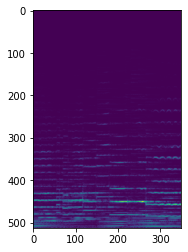

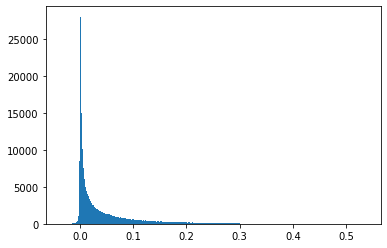

Max bin: -5.335983559728169e-05
Using whichChannel == freq  Input shape: torch.Size([1, 513, 1, 349])


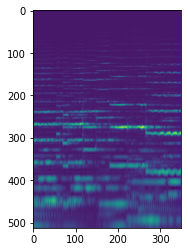

In [10]:
R, fs = read_audio_spectum(STYLE_FILENAME)
print(R.shape)
print("STFT range before scaling:",np.amin(R),np.amax(R))
a_style = log_scale(R[:,:349])
print("STFT range after log scaling:",np.amin(a_style),np.amax(a_style))

fig2 = plt.figure() #figsize=(10, 5)
#plt.title('Style spectrogram')
plt.imshow(np.flipud(a_style))

a_style, cqtinfo = spect2CQT(a_style,N_FFT,10)

if use01scale == True:
    a_min,a_max = findMinMax(a_style)
    #a_style = img_scale(a_style,a_min,a_max,0,1)
    a_style = img_scale(a_style,0,7,0,1)
    print("STFT range after [0,1] scaling:",np.amin(a_style),np.amax(a_style))
     

"""we plot out the STFT magnitude range and the spectrogram do get a feel of the data"""
#plt.ion()
fig = plt.figure()
#plt.title('Style histogram')
ax = fig.add_subplot(111)
n,b,_ = ax.hist(a_style.flatten(),bins='auto')
maxbin = np.argmax(n)
plt.show()
fig.savefig('experiments/'+outname+'/'+savename_style+'_styleinput'+'_hist.png',bbox_inches='tight')
print("Max bin:",b[maxbin])

fig2 = plt.figure() #figsize=(10, 5)
#plt.title('Style spectrogram')
plt.imshow(np.flipud(a_style))
fig2.savefig('experiments/'+outname+'/'+savename_style+'_styleinput'+'.png',bbox_inches='tight')

"""
a_style = img_invscale(a_style,0,7,0,1)
spec = CQT2spec(a_style,cqtinfo)
fig3 = plt.figure() #figsize=(10, 5)
#plt.title('Style spectrogram')
plt.imshow(np.flipud(spec))
print("STFT range after undoing CQT scaling:",np.amin(spec),np.amax(spec))
"""
N_SAMPLES = a_style.shape[1] #time bins
N_FREQ = a_style.shape[0] #freq bins

a_style = np.ascontiguousarray(a_style[None,None,:,:]) #[batch,channels,freq,samples]
if whichChannel == "2d":
    a_style = torch.from_numpy(a_style) #pytorch:[batch,channels(1),height(freq),width(samples)]
elif whichChannel == "freq":
    a_style = torch.from_numpy(a_style).permute(0,2,1,3) #pytorch:[batch,channels(freq),height(1),width(samples)]
elif whichChannel == "time":
    a_style = torch.from_numpy(a_style).permute(0,3,1,2) #pytorch:[batch,channels(samples),height(1),width(freq)]

style_img = Variable(a_style).type(dtype) #convert to pytorch variable
print("Using whichChannel ==",whichChannel," Input shape:",style_img.data.shape) #check shape is correct

(513, 2586)
STFT range before scaling: 1.407576e-08 108.58911
STFT range after log scaling: 1.407576e-08 4.6967382
opr is 2018
H is 513


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Using [0,7] -> [0,1] for scale conversion
STFT range after [0,1] scaling: -0.045478173400190815 0.6637024572810705


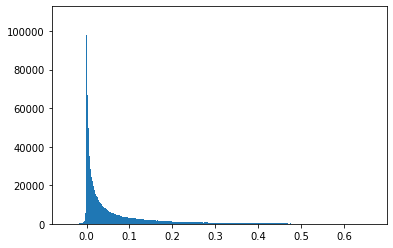

Max bin: 0.0006581129824191206
Using whichChannel == freq  Input shape: torch.Size([1, 513, 1, 2586])


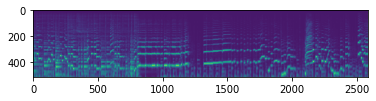

In [11]:
if CONTENT_FILENAME is not None:
    R, fs = read_audio_spectum(CONTENT_FILENAME)
    print(R.shape)
    print("STFT range before scaling:",np.amin(R),np.amax(R))
    a_cont = log_scale(R[:,:])
    print("STFT range after log scaling:",np.amin(a_cont),np.amax(a_cont))
    
    a_cont, cqtinfo_cont = spect2CQT(a_cont,N_FFT)
    
    if use01scale == True:
        a_min,a_max = findMinMax(a_cont)
        a_cont = img_scale(a_cont,0,7,0,1)
        print("STFT range after [0,1] scaling:",np.amin(a_cont),np.amax(a_cont))

    """we plot out the STFT magnitude range and the spectrogram do get a feel of the data"""
    #plt.ion()
    fig6 = plt.figure()
    #plt.title('Content histogram')
    ax = fig6.add_subplot(111)
    n,b,_ = ax.hist(a_cont.flatten(),bins='auto')
    maxbin = np.argmax(n)
    plt.show()
    fig6.savefig('experiments/'+outname+'/'+savename_style+'_continput'+'_hist.png',bbox_inches='tight')
    print("Max bin:",b[maxbin])

    fig5 = plt.figure() #figsize=(10, 5)
    #plt.title('Content spectrogram')
    plt.imshow(np.flipud(a_cont))
    fig5.savefig('experiments/'+outname+'/'+savename_style+'_continput'+'.png',bbox_inches='tight')


    N_SAMPLES = a_cont.shape[1] #time bins
    N_FREQ = a_cont.shape[0] #freq bins

    a_cont = np.ascontiguousarray(a_cont[None,None,:,:]) #[batch,channels,freq,samples]
    if whichChannel == "2d":
        a_cont = torch.from_numpy(a_cont) #pytorch:[batch,channels(1),height(freq),width(samples)]
    elif whichChannel == "freq":
        a_cont = torch.from_numpy(a_cont).permute(0,2,1,3) #pytorch:[batch,channels(freq),height(1),width(samples)]
    elif whichChannel == "time":
        a_cont = torch.from_numpy(a_cont).permute(0,3,1,2) #pytorch:[batch,channels(samples),height(1),width(freq)]

    cont_img = Variable(a_cont).type(dtype) #convert to pytorch variable
    print("Using whichChannel ==",whichChannel," Input shape:",cont_img.data.shape) #check shape is correct
    
else:
    cont_img = None

(513, 349)
Output range: -0.03606438 0.5363213


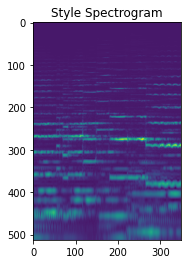

array([[ 0.09077067,  0.10237259,  0.11283787, ...,  0.02896159,
         0.00286603,  0.03382101],
       [ 0.16131926,  0.18047139,  0.2022581 , ...,  0.05291768,
         0.00658535,  0.05974912],
       [ 0.14691949,  0.16320613,  0.18678905, ...,  0.05099515,
         0.01026983,  0.05545798],
       ...,
       [-0.00336065, -0.00453394, -0.00557699, ..., -0.00143319,
        -0.00029439, -0.00178549],
       [ 0.00734411,  0.00785433,  0.00825758, ...,  0.00215107,
         0.00040507,  0.00262431],
       [-0.01097638, -0.01314281, -0.01509344, ..., -0.00387577,
        -0.00053195, -0.00464163]], dtype=float32)

In [12]:
def imshow(tensor, channels=1, title=None):
    """ transforms pytorch tensor to numpy array and plots it out """
    
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    if whichChannel == "2d":
        image = image
    if whichChannel == "freq":
        image = image.permute(0,2,1,3).contiguous() # get the dimensions in proper order
    elif whichChannel == "time":
        image = image.permute(0,2,3,1).contiguous() # get the dimensions in proper order
    image = image.view(N_FREQ,-1) #N_SAMPLES # remove the fake batch dimension
    
    image = image.numpy() #convert pytorch tensor to numpy array
    print(image.shape) #check shape
    print("Output range:",np.amin(image),np.amax(image))
    
    plt.imshow(np.flipud(image))
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    return image #return numpy array

"Just to check we can get back the numpy array with the correct shape"
plt.figure()
imshow(style_img.data, title='Style Spectrogram')

#plt.figure()
#imshow(content_img.data, title='Content Image')

In [13]:
"Here we create the custom network"
import collections as c
    
#if useVGG == True:
#cnn = models.vgg19(pretrained=True).features
#print(list(cnn))

if whichChannel == "2d":
    IN_CHANNELS = 1
elif whichChannel == "freq":
    IN_CHANNELS = N_FREQ
elif whichChannel == "time":
    IN_CHANNELS = N_SAMPLES

def weights_init(m):    
# custom weights initialization
    std = np.sqrt(2) * np.sqrt(2.0 / ((IN_CHANNELS + N_FILTERS) * hor_filter))  #~0.01
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0,std) #

#params = load_obj(param_pkl) 

#cnn = CNN(params['l1channels'],params['l2channels'],params['l3channels'],params['orientation'],
          #params['in_height'],params['in_width'],params['in_channels'],params['n_classes'],params['kernelsize'])
cnn = CNN(N_FILTERS,1,1,'freq',
          1,517,513,N_FILTERS,hor_filter)
if model_path is not None: # load checkpoint if needed
    print("loading weights...")
    cnn.load_state_dict(torch.load(model_path))
print(cnn)
if use_cuda:
    cnn.cuda()
#print(cnn.layer1[0].weight)
#cnn.apply(weights_init)
cnn.eval()
for param in cnn.parameters():
    param.requires_grad = False


class style_net(nn.Module):
    """Here create the network you want to use by adding/removing layers in nn.Sequential"""
    def __init__(self):
        super(style_net, self).__init__()
        self.layer1 = nn.Sequential(c.OrderedDict([
                            ('conv1',nn.Conv2d(IN_CHANNELS,N_FILTERS,kernel_size=(1,hor_filter),padding=(0,5))),
                            ('bnorm1',nn.BatchNorm2d(N_FILTERS)),
                            #('relu1',nn.ReLU()),
                            #('max1', nn.MaxPool2d(kernel_size=(1,2))),
                            #('conv2',nn.Conv2d(N_FILTERS,N_FILTERS//2,kernel_size=(1,hor_filter),bias=False)),
                            #('relu2',nn.ReLU())
        ])) 
        
    def forward(self,input):
        out = self.layer1(input)
        return out

"""
cnn = style_net()
#cnn.apply(weights_init)
cnn.eval()
for param in cnn.parameters():
    param.requires_grad = False
print(list(cnn.layer1))

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()
"""
# Add the style/content loss 'layer' after the specified layer:
content_layers_default = ['relu_3'] #ignore for now
style_layers_default = ['relu_1'] #'relu_1','relu_2'

CNN(
  (layer1): Sequential(
    (0): Conv2d(513, 4096, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5))
    (1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(4096, 1, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(1, 1, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=64, out_features=4096, bias=True)
)


Content loss
~~~~~~~~~~~~

The content loss is a function that takes as input the feature maps
$F_{XL}$ at a layer $L$ in a network fed by $X$ and
return the weigthed content distance $w_{CL}.D_C^L(X,C)$ between
this image and the content image. Hence, the weight $w_{CL}$ and
the target content $F_{CL}$ are parameters of the function. We
implement this function as a torch module with a constructor that takes
these parameters as input. The distance $\|F_{XL} - F_{YL}\|^2$ is
the Mean Square Error between the two sets of feature maps, that can be
computed using a criterion ``nn.MSELoss`` stated as a third parameter.

We will add our content losses at each desired layer as additive modules
of the neural network. That way, each time we will feed the network with
an input image $X$, all the content losses will be computed at the
desired layers and, thanks to autograd, all the gradients will be
computed. For that, we just need to make the ``forward`` method of our
module returning the input: the module becomes a ''transparent layer''
of the neural network. The computed loss is saved as a parameter of the
module.

Finally, we define a fake ``backward`` method, that just call the
backward method of ``nn.MSELoss`` in order to reconstruct the gradient.
This method returns the computed loss: this will be useful when running
the gradient descent in order to display the evolution of style and
content losses.




In [14]:
class ContentLoss(nn.Module):
    """Since doing texture only we ignore this for now"""

    def __init__(self, target, weight): #weight here is the epsilon tuning (how much content vs style)
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() #* weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.weight * self.criterion(input, self.target) #input*self.weight
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=retain_variables)
        return self.loss

.. Note::
   **Important detail**: this module, although it is named ``ContentLoss``,
   is not a true PyTorch Loss function. If you want to define your content
   loss as a PyTorch Loss, you have to create a PyTorch autograd Function
   and to recompute/implement the gradient by the hand in the ``backward``
   method.

Style loss
~~~~~~~~~~

For the style loss, we need first to define a module that compute the
gram produce $G_{XL}$ given the feature maps $F_{XL}$ of the
neural network fed by $X$, at layer $L$. Let
$\hat{F}_{XL}$ be the re-shaped version of $F_{XL}$ into a
$K$\ x\ $N$ matrix, where $K$ is the number of feature
maps at layer $L$ and $N$ the lenght of any vectorized
feature map $F_{XL}^k$. The $k^{th}$ line of
$\hat{F}_{XL}$ is $F_{XL}^k$. We let you check that
$\hat{F}_{XL} \cdot \hat{F}_{XL}^T = G_{XL}$. Given that, it
becomes easy to implement our module:




In [15]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size() #a=batch size(=1)
                                  #b=number of feature maps
                                  #(c,d)=dimensions of a feat. map (N=c*d) -> for 1D conv c=1
        #features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
        features = input.view(b, a * c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * c * d)

The longer is the feature maps dimension $N$, the bigger are the
values of the gram matrix. Therefore, if we don't normalize by $N$,
the loss computed at the first layers (before pooling layers) will have
much more importance during the gradient descent. We dont want that,
since the most interesting style features are in the deepest layers!

Then, the style loss module is implemented exactly the same way than the
content loss module, but we have to add the ``gramMatrix`` as a
parameter:




In [16]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight): #weight here is the alpha tuning (how much content vs style)
        super(StyleLoss, self).__init__()
        self.target = target.detach() #* weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss() #size_average=False

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        #self.G.mul_(self.weight)
        self.loss = self.weight * self.criterion(self.G, self.target) #target=gram mat for style img, G=gram mat for current input ie. noise
        return self.output

    def backward(self):
        self.loss.backward(retain_graph=True)
        return self.loss

In [17]:
class OptReg(nn.Module):
    """soft bound the optimization between [lower,upper] by regularization"""
    
    def __init__(self, upper, lower, weight): #weight here is the alpha tuning (how much content vs style)
        super(OptReg, self).__init__()
        self.upper = Variable(torch.cuda.FloatTensor([upper]))
        self.lower = Variable(torch.cuda.FloatTensor([lower]))
        self.weight = weight

    def forward(self, input):
        self.zeros = Variable(torch.zeros(input.size()).type(dtype))
                              
        self.over = torch.max(input-self.upper,self.zeros)
        self.under = torch.max(self.lower-input,self.zeros)
        self.total= self.over + self.under
        self.l2total = self.weight * self.total.norm(2)
        return self.l2total

Load the neural network
~~~~~~~~~~~~~~~~~~~~~~~

Now, we have to import a pre-trained neural network. As in the paper, we
are going to use a pretrained VGG network with 19 layers (VGG19).

PyTorch's implementation of VGG is a module divided in two child
``Sequential`` modules: ``features`` (containing convolution and pooling
layers) and ``classifier`` (containing fully connected layers). We are
just interested by ``features``:




A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (Conv2d, ReLU,
Maxpool2d, Conv2d, ReLU...) aligned in the right order of depth. As we
said in *Content loss* section, we wand to add our style and content
loss modules as additive 'transparent' layers in our network, at desired
depths. For that, we construct a new ``Sequential`` module, in wich we
are going to add modules from ``vgg19`` and our loss modules in the
right order:




In [18]:
#rebuild network with the layers we want
def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight, content_weight,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []
    
    model = nn.Sequential()
    layer_list =  list(cnn.layer1) + list(cnn.layer2) + list(cnn.layer3)  #.layers
    
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    #here we rebuild the network adding the in content and style loss "layers"   
    i = 1  
    for layer in layer_list:
        
        if isinstance(layer, nn.Conv2d): #if layer in vgg19 belong to class nn.Conv2d
            name = "conv_" + str(i)
            model.add_module(name, layer) #add that layer to our sequential model
            
            if content_img is not None:
                if name in content_layers: #at the right depth add the content loss "layer"
                    # add content loss:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)

            if name in style_layers: #at the right depth add the content loss "layer"
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU): #do the same for ReLUs
            name = "relu_" + str(i)
            model.add_module(name, layer)
            
            if content_img is not None:
                if name in content_layers:
                    # add content loss:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
            
        if isinstance(layer, nn.BatchNorm2d): #do the same for maxpool
            name = "batchnorm_" + str(i)
            model.add_module(name, layer)
            
            if content_img is not None:
                if name in content_layers:
                    # add content loss:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)
            
            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
                 
        if isinstance(layer, nn.MaxPool2d): #do the same for maxpool
            name = "pool_" + str(i)
            model.add_module(name, layer)
            
            if content_img is not None:
                if name in content_layers:
                    # add content loss:
                    target = model(content_img).clone()
                    content_loss = ContentLoss(target, content_weight)
                    model.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)
            
            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
            
            #avgpool = nn.AvgPool2d(kernel_size=(1,2),
            #                stride=layer.stride, padding = layer.padding)
            #model.add_module(name, avgpool)  # *** can also replace certain layers if we want eg. maxpool -> avgpool
            i += 1


    #for param in model.parameters():
    #    param.requires_grad = False
    return model, style_losses, content_losses

.. Note::
   In the paper they recommend to change max pooling layers into
   average pooling. With AlexNet, that is a small network compared to VGG19
   used in the paper, we are not going to see any difference of quality in
   the result. However, you can use these lines instead if you want to do
   this substitution:

   ::

       # avgpool = nn.AvgPool2d(kernel_size=layer.kernel_size,
       #                         stride=layer.stride, padding = layer.padding)
       # model.add_module(name,avgpool)



Input image
~~~~~~~~~~~

Again, in order to simplify the code, we take an image of the same
dimensions than content and style images. This image can be a white
noise, or it can also be a copy of the content-image.




In [19]:
"""image to input in generative network"""
#input_img = content_img.clone()

# if you want to use a white noise instead uncomment the below line:
#input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

def in_img():
    """initialize (runs) number of unique random noise input images"""  
    input_imgs = []
    #rand_tensor = torch.randn(1,N_FREQ,1,N_SAMPLES)*1e-3
    lower,upper,mu,sigma = 0,1,1e-3,1e-1
    dist = stats.truncnorm((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)
    
    i = 0
    while i < runs:
         #[batch,channels,h,w]
        if whichChannel == "2d":
            #samples = dist.rvs([1,1,N_FREQ,N_SAMPLES])
            #input_imgs.append(Variable(torch.from_numpy(samples)).type(dtype))
            input_imgs.append(Variable(torch.rand(1,1,N_FREQ,N_SAMPLES)*1e-1).type(dtype))
            #input_imgs.append(Variable(torch.randn(1,1,N_FREQ,N_SAMPLES)*1e-3).type(dtype))
            #input_imgs.append(cont_img.clone())
        if whichChannel == "freq":
            #samples = dist.rvs([1,N_FREQ,1,N_SAMPLES])
            #input_imgs.append(Variable(torch.from_numpy(samples)).type(dtype))
            #input_imgs.append(Variable(torch.rand(1,N_FREQ,1,N_SAMPLES)*1e-1).type(dtype))
            #input_imgs.append(Variable(torch.randn(1,N_FREQ,1,N_SAMPLES)*1e-3).type(dtype))
            input_imgs.append(cont_img.clone())
        elif whichChannel == "time":
            #samples = dist.rvs([1,N_SAMPLES,1,N_FREQ])
            #input_imgs.append(Variable(torch.from_numpy(samples)).type(dtype))
            input_imgs.append(Variable(torch.rand(1,N_SAMPLES,1,N_FREQ)*1e-1).type(dtype))
            #input_imgs.append(Variable(torch.randn(1,N_SAMPLES,1,N_FREQ)*1e-3).type(dtype))
            #input_imgs.append(cont_img.clone())
        
        i +=1
    return input_imgs

input_imgs = in_img()

# add the original input image to the figure:
#plt.figure()
#imshow(input_img.data, title='Input Image')

Gradient descent
~~~~~~~~~~~~~~~~

As Leon Gatys, the author of the algorithm, suggested
`here <https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq>`__,
we will use L-BFGS algorithm to run our gradient descent. Unlike
training a network, we want to train the input image in order to
minimise the content/style losses. We would like to simply create a
PyTorch  L-BFGS optimizer, passing our image as the variable to optimize.
But ``optim.LBFGS`` takes as first argument a list of PyTorch
``Variable`` that require gradient. Our input image is a ``Variable``
but is not a leaf of the tree that requires computation of gradients. In
order to show that this variable requires a gradient, a possibility is
to construct a ``Parameter`` object from the input image. Then, we just
give a list containing this ``Parameter`` to the optimizer's
constructor:




In [20]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

**Last step**: the loop of gradient descent. At each step, we must feed
the network with the updated input in order to compute the new losses,
we must run the ``backward`` methods of each loss to dynamically compute
their gradients and perform the step of gradient descent. The optimizer
requires as argument a "closure": a function that reevaluates the model
and returns the loss.

In [23]:
def run_style_transfer(cnn, style_img, input_img, content_img=None, num_steps=500,
                       style_weight=1e7, content_weight=1, reg_weight=1e-3):
    """Run the style transfer"""
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)
    
    print("Input range:",torch.max(input_param.data),torch.min(input_param.data))   
    print(model)
    print('Optimizing..')
    run = [0]
    
    if boundopt == True:
        bound = OptReg(1,0,weight=reg_weight)
    
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            #if use01scale == True:
                #input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0
          
            if boundopt == True:
                bound.zero_grad()
                reg = bound(input_param)
                if not torch.equal(reg.data,torch.cuda.FloatTensor([0])):
                    reg.backward()

            for sl in style_losses:
                style_score += sl.backward() #call backward method to grab the loss
            
            if content_img is not None:
                for cl in content_losses:
                    content_score += cl.backward()
            
                if boundopt == True:
                    total_loss = style_score + reg + content_score
                else:
                    total_loss = style_score + content_score
                    
            else:            
                if boundopt == True:
                    total_loss = style_score + reg
                else:
                    total_loss = style_score
            
            if run[0] % 50 == 0:
                #print("reg", reg)
                #print(torch.max(input_param.data),torch.min(input_param.data))
                
                print("run {}:".format(run))
                print('Style Loss : {:4f}'.format(
                    style_score.data))
                if content_img is not None:
                    print('Content Loss : {:4f}'.format(
                       content_score.data))
                if boundopt == True:
                    print('Bound Loss : {:4f}'.format(
                       reg.data))
                print(torch.max(input_param.data),torch.min(input_param.data))
                print('Total Loss : {:4f}'.format(
                    total_loss.data))
            
            run[0] += 1             
            return total_loss   
        
        optimizer.step(closure)
        
    # a last correction...
    #if use01scale == True:
        #input_param.data.clamp_(0, 1)

    return input_param.data

Finally, run the algorithm



Building the style transfer model..
Input range: tensor(0.6637, device='cuda:0') tensor(-0.0455, device='cuda:0')
Sequential(
  (conv_1): Conv2d(513, 4096, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5))
  (batchnorm_1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (style_loss_1): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (pool_1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(4096, 1, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5))
  (batchnorm_2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(1, 1, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5))
  (batchnorm_3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_3): ReLU()
  (conte

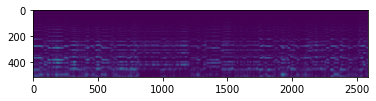

In [24]:
outputs = []
i = 0
#print(cont_img.data.shape)
while i < runs:
    
    output = run_style_transfer(cnn, style_img, input_imgs[i], cont_img)

    fig3 = plt.figure()
    out = imshow(output) #, title='Output Image'
    fig3.savefig('experiments/'+outname+'/'+savename_style+'_output'+'.png',bbox_inches='tight')
    outputs.append(out)
    i += 1

# sphinx_gallery_thumbnail_number = 4
plt.show()

Range from opt: -2.0395855e-05 0.99234563


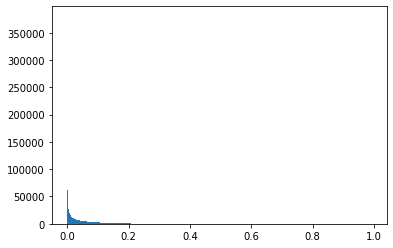

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


opr is 2018
H is 513
Using [0,1] -> [0,7] for scale conversion
Range after undoing all scaling: 0.0 570.2919948787877


In [25]:
#out_spec = inv_scale(out,shf)
for j in range(len(outputs)):
    print("Range from opt:",np.amin(outputs[j]),np.amax(outputs[j])) # check values make sense
    fig4 = plt.figure()
    #plt.title('Style histogram')
    ax = fig4.add_subplot(111)
    n,b,_ = ax.hist(outputs[j].flatten(),bins='auto')
    plt.show()
    fig4.savefig('experiments/'+outname+'/'+savename_style+'_output'+'_hist.png',bbox_inches='tight')
    
if use01scale == True:
    out_spec = [CQT2spec(x,cqtinfo) for x in outputs]
    out_spec = [inv_log(img_invscale(x,0,7,0,1)) for x in out_spec]
    out_spec = [np.maximum(img, 0.) for img in out_spec]
else:
    out_spec = [CQT2spec(x,cqtinfo) for x in outputs]
    out_spec = [inv_log(x) for x in out_spec]

for j in range(len(out_spec)):
    print("Range after undoing all scaling:",np.amin(out_spec[j]),np.amax(out_spec[j])) # check values make sense

In [27]:
import soundfile as sf

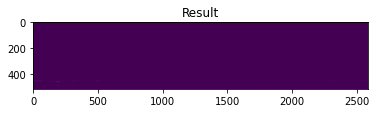

In [28]:
for index,value in enumerate(out_spec):
    p = 2 * np.pi * np.random.random_sample(value.shape) - np.pi #start with some phase
    for i in range(500):
        S = value * np.exp(1j*p) #use magnitude a given by spectrogram and some random phase
        x = librosa.istft(S,hop_length=K_HOP, win_length=N_FFT, center=True) #do the inverse transform
        p = np.angle(librosa.stft(x, n_fft=N_FFT, hop_length=K_HOP, win_length=N_FFT, center=True)) #use this new phase value
    try:
        os.stat("experiments/" + outname) # test for existence
    except:
        os.mkdir("experiments/" + outname) # create if necessary    
    sf.write("experiments/" + outname + '/' + savename_style + '_' + str(index) + '.wav', x, fs)
    plt.figure()
    plt.title('Result')
    plt.imshow(np.flipud(value))
    plt.show()

plt.ioff()

In [29]:
display(Audio('/content/experiments/input/CrichSrooster_cqt_0.wav'))